# Assignment 2

Welcome to the assignment for week 2.

## Task 2: Convolution and Canny edge detection

### Task 2.1: Convolution
Implement the convolution operation for 2-D images (i.e. no colors here, sorry).

In [12]:
# imports
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.filters import gaussian
import numpy as np

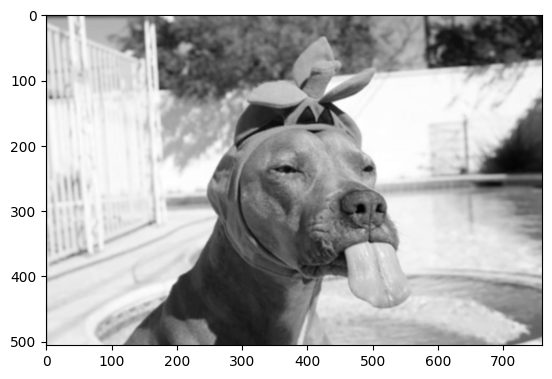

In [17]:
def conv2d(image, kernel):
    
    ylen, xlen = image.shape
    wlen, hlen = kernel.shape
    pad_h, pad_w = hlen // 2, wlen // 2
    
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)))
    result = image.copy()
    
    #return result # padding is good
    
    for x in range(xlen):
        for y in range(ylen):
            
            for w in range(wlen):
                for h in range(hlen):
                    result[y][x] += padded[y-h+pad_h][x-w+pad_w]*kernel[w][h]
    
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(conv2d(image, np.array([[1,1,1],[1,1,1],[1,1,1]])), cmap='gray')

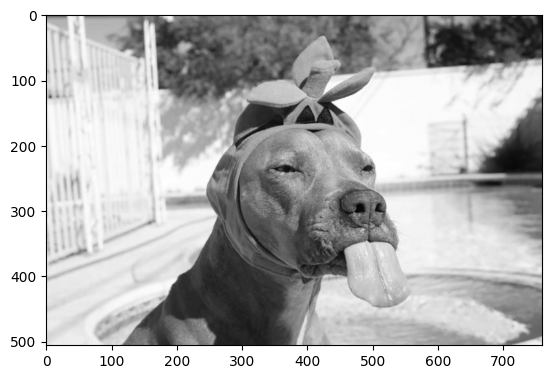

In [20]:
# just for comparasion

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(image, cmap='gray')

if (image == conv2d(image, np.array([[1,1,1],[1,1,1],[1,1,1]]))).all():
    print('Convolution gives new Image')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show the results using your conv2d()-function.  (***RESULT***).

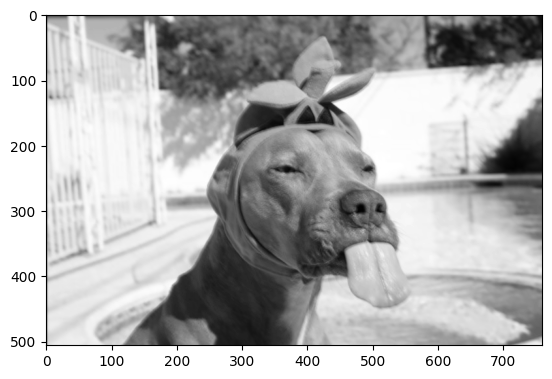

In [29]:
# CHat GPT helped a lot here
# didn't know gauss kernel
# or use gaussian from skimage.filters

def gauKernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    gauss = np.exp(-0.5 * (ax / sigma) ** 2)
    kernel = np.outer(gauss, gauss)
    
    return kernel / np.sum(kernel) # norm

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(conv2d(image, gauKernel(5)), cmap='gray')


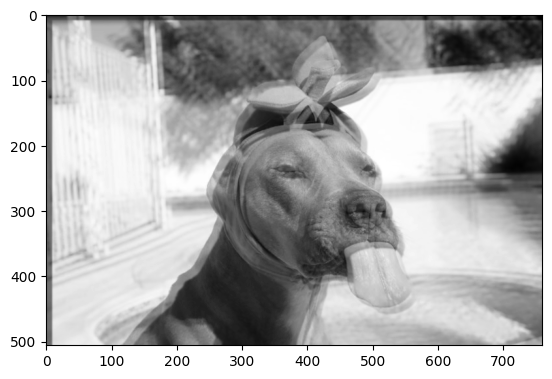

In [30]:

plt.imshow(conv2d(image, gauKernel(20)), cmap='gray')
# aua tut das in den Augen weh

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

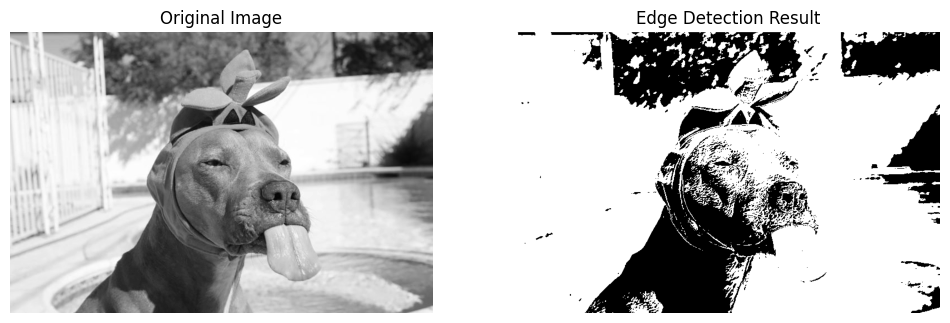

In [32]:

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

grad_x = conv2d(image, sobel_x)
grad_y = conv2d(image, sobel_y)

gradient_magnitude = np.sqrt(conv2d(image, sobel_x)**2 + conv2d(image, sobel_y)**2)

threshold = 0.7
edges = gradient_magnitude > threshold

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Edge Detection Result")
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

# TODO understand the result !?

### Task 2.2: Canny Edge Detection

#### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices according to the lecture. Round the gradient directions to the 8-neighbor's directions. Display all intermediate ***RESULT***s!

In [38]:
# I choice skimage
smoothImage = conv2d(image, gauKernel(5))

grad_x_smoothed = conv2d(smoothImage, sobel_x)
grad_y_smoothed = conv2d(smoothImage, sobel_y)
gradient_magnitude_smoothed = np.sqrt(grad_x_smoothed**2 + grad_y_smoothed**2)
edges_smoothed = gradient_magnitude_smoothed > threshold

# TODO understand direction matrix

#### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

In [ ]:
# code here

#### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)

In [ ]:
# code here

## Congratz, you made it! :)